# Spectra loader for TSMC-Net.



In [2]:
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.ticker import MaxNLocator
import numpy as np
from numpy import asarray
import pandas as pd
import math
import seaborn as sns  #heat map
import glob # batch processing of images


import matplotlib.font_manager as fm
import random
import sys
import os

from sklearn.datasets import make_regression
import tensorflow as tf
from sklearn.metrics import confusion_matrix    #confusion matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Collect all the font names available to matplotlib
font_names = [f.name for f in fm.fontManager.ttflist]
# print(font_names)

from scipy import signal
from scipy import interpolate

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve 
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score


from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process.kernels import RBF

#Sklearn model saving and loading
from joblib import dump, load

if '../../' not in sys.path:
    sys.path.append('../../')

from aimos.spectral_datasets.THz_datasets import THz_data

from aimos.misc.utils import simple_plotter


#Set random seed
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.random.set_seed(42)  
tf.random.get_global_generator().reset_from_seed(42)
np.random.seed(42)
random.seed(42)



2022-09-05 17:46:25.009282: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-09-05 17:46:26.053857: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-09-05 17:46:26.081847: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 4000 computeCapability: 7.5
coreClock: 1.545GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 387.49GiB/s
2022-09-05 17:46:26.081897: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-09-05 17:46:26.087042: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-09-05 17:46:26.087241: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so

In [3]:
from oneida import THz_mixture_data
from oneida_utils import concentrations_to_one_hot_encode, create_mixture_names

# Retrieve training(D)+ validation(V) mixtures and its variables

In [4]:
m = THz_mixture_data(resolution=0.016, pressure='1 Torr', verbosity=False)
m.initiate_THz_mixture_data()

reduced_labels = m.labels
reduced_labels.remove('')
reduced_labels.remove(' ')
reduced_labels.remove('Diluent')
print(reduced_labels)



Components :  [[0 1 2 3 4 5]]
Components shape :  (1, 6)
['$CH_3CHO$', '$CH_3Cl$', '$CH_3CN$', '$CH_3OH$', '$HNO_3$']


In [5]:
import operator as op
from functools import reduce

def ncr(n, r):
    r = min(r, n-r)
    numer = reduce(op.mul, range(n, n-r, -1), 1)
    denom = reduce(op.mul, range(1, r+1), 1)
    return numer // denom  # or / in Python 2

n_compounds = m.n_compounds
unique_mixture_numbers = ncr(n_compounds,1) + ncr(n_compounds,2) + ncr(n_compounds,3) + ncr(n_compounds,4) + ncr(n_compounds,5) 
# unique_mixture_numbers = ncr(n_compounds,1) + ncr(n_compounds,2) + ncr(n_compounds,3) + ncr(n_compounds,4) + ncr(n_compounds,5) + ncr(n_compounds,6) + ncr(n_compounds,7) +ncr(n_compounds,8) + ncr(n_compounds,9) + ncr(n_compounds,10) + ncr(n_compounds,11) + ncr(n_compounds,12)
print(unique_mixture_numbers)

31


In [6]:
DV = pd.read_pickle("datasets/TSMCN-5-L-229_DV_04-09-2022_time_22-26-37.pkl")

In [7]:
DV.columns

Index([              0,               1,               2,               3,
                     4,               5,               6,               7,
                     8,               9,
       ...
                   226,             227,             228,             'y',
       'mixture_names',          'y_c0',          'y_c1',          'y_c2',
                'y_c3',          'y_c4'],
      dtype='object', length=236)

In [8]:
y = DV['y'].to_numpy()
mixture_names = DV['mixture_names'].to_numpy()
y_concentrations = DV[['y_c0', 'y_c1', 'y_c2','y_c3', 'y_c4']].to_numpy()
X = DV.drop(['y','mixture_names', 'y_c0', 'y_c1', 'y_c2','y_c3', 'y_c4'],axis=1).to_numpy()

In [9]:
final_neuron_number = np.unique(y, axis=0).shape[0]
print(final_neuron_number)

31


# preview one test mixture spectra using simple plotter

In [10]:
m.labels

['$CH_3CHO$', '$CH_3Cl$', '$CH_3CN$', '$CH_3OH$', '$HNO_3$']

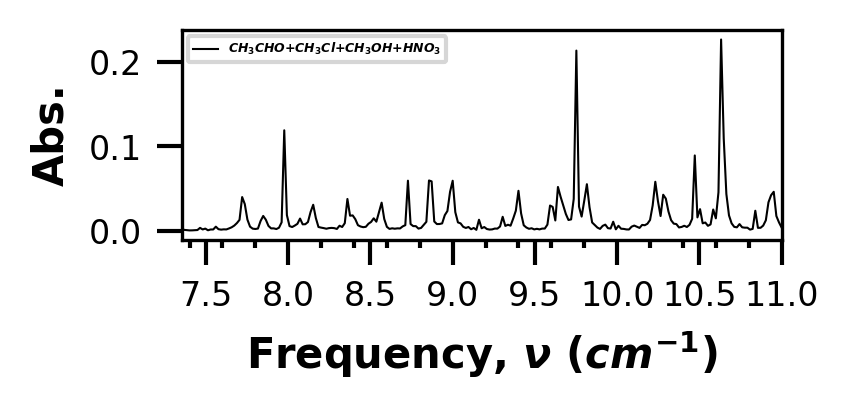

[0.054471740705492586 0.09497894560913117 0.0 0.05892703383510154
 0.058579141816225526]
['$CH_3CHO$', '$CH_3Cl$', '$CH_3CN$', '$CH_3OH$', '$HNO_3$']


In [11]:
idx = 22200
simple_plotter(m.frequencies,X[idx],linewidth=0.5,color='black',label=mixture_names[idx], 
                   majorsize=6,minorsize=2,width=1, labelsize=8,legendsize=3, legendloc=2,  
                   labelpad=4,fontsize='medium',fontweight='bold',
                  xmajormplloc=0.5,xminormplloc=0.2, tickdirection='out')

print(y_concentrations[idx])
print(reduced_labels)

In [13]:


from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(mixture_names)

mixture_types=le.classes_
print(mixture_types)

['$CH_3CHO$' '$CH_3CHO$+$CH_3CN$' '$CH_3CHO$+$CH_3CN$+$CH_3OH$'
 '$CH_3CHO$+$CH_3CN$+$CH_3OH$+$HNO_3$' '$CH_3CHO$+$CH_3CN$+$HNO_3$'
 '$CH_3CHO$+$CH_3Cl$' '$CH_3CHO$+$CH_3Cl$+$CH_3CN$'
 '$CH_3CHO$+$CH_3Cl$+$CH_3CN$+$CH_3OH$'
 '$CH_3CHO$+$CH_3Cl$+$CH_3CN$+$CH_3OH$+$HNO_3$'
 '$CH_3CHO$+$CH_3Cl$+$CH_3CN$+$HNO_3$' '$CH_3CHO$+$CH_3Cl$+$CH_3OH$'
 '$CH_3CHO$+$CH_3Cl$+$CH_3OH$+$HNO_3$' '$CH_3CHO$+$CH_3Cl$+$HNO_3$'
 '$CH_3CHO$+$CH_3OH$' '$CH_3CHO$+$CH_3OH$+$HNO_3$' '$CH_3CHO$+$HNO_3$'
 '$CH_3CN$' '$CH_3CN$+$CH_3OH$' '$CH_3CN$+$CH_3OH$+$HNO_3$'
 '$CH_3CN$+$HNO_3$' '$CH_3Cl$' '$CH_3Cl$+$CH_3CN$'
 '$CH_3Cl$+$CH_3CN$+$CH_3OH$' '$CH_3Cl$+$CH_3CN$+$CH_3OH$+$HNO_3$'
 '$CH_3Cl$+$CH_3CN$+$HNO_3$' '$CH_3Cl$+$CH_3OH$'
 '$CH_3Cl$+$CH_3OH$+$HNO_3$' '$CH_3Cl$+$HNO_3$' '$CH_3OH$'
 '$CH_3OH$+$HNO_3$' '$HNO_3$']


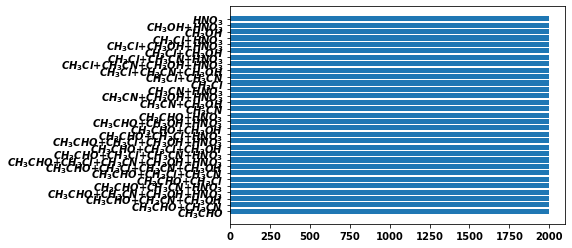

In [14]:
#see distribution of counts of different types of mixtures.
plt.barh(mixture_types,np.bincount(y))
plt.xticks(rotation=90);
plt.xticks(rotation=0);

In [15]:
#split intro train and test set

#seeds used 123,237, 786
from sklearn.model_selection import train_test_split

global_indices=range(0, X.shape[0])
print(global_indices)

# (np.expand_dims(X,-1)
TRAIN_SIZE=0.60
TEST_SIZE=1-TRAIN_SIZE

x_train, x_test, y_train, y_test, train_indices, test_indices = train_test_split(np.expand_dims(X, axis=-1), y, global_indices, train_size=TRAIN_SIZE,
                                                   test_size=TEST_SIZE,
                                                   random_state=786,
                                                    stratify=y

                                                   )

print('X_train shape:', x_train.shape)
print('y_ohe_train shape:', y_train.shape)

print('X_test shape:', x_test.shape)
print('y_ohe_test shape:', y_test.shape)


print("All:", np.bincount(y) / float(len(y))*100  )
print("Training:", np.bincount(y_train) / float(len(y_train))*100  )
print("Testing:", np.bincount(y_test) / float(len(y_test))*100  )


range(0, 62000)
X_train shape: (37200, 229, 1)
y_ohe_train shape: (37200,)
X_test shape: (24800, 229, 1)
y_ohe_test shape: (24800,)
All: [3.22580645 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645
 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645
 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645
 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645
 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645
 3.22580645]
Training: [3.22580645 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645
 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645
 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645
 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645
 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645
 3.22580645]
Testing: [3.22580645 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645
 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645 3.22580645
 3.22580645 3.

In [16]:
y_test

array([28,  7, 17, ...,  2, 20, 27])

# notebook ends!